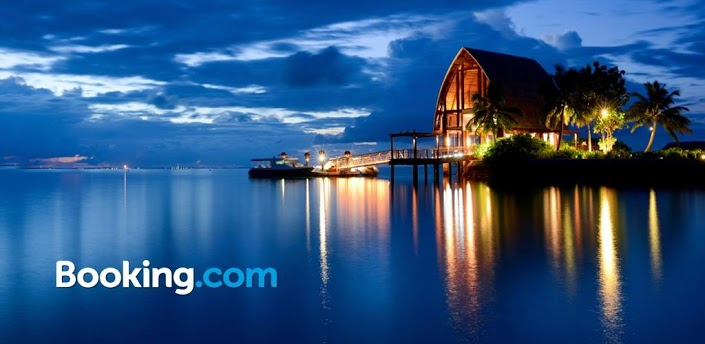

# Содержание
- [1. Библиотеки](#1.Библиотеки)
- [2. Исследование структуры данных](#2.Исследование-структуры-данных)
    * [2.1 Объединение train и test датафреймов](#2.1-Объединение-train-и-test-датафреймов)
- [3. Преобразование данных](#3.Преобразование-данных)
- [4.Очистка данных](#4.Очистка-данных)
    * [4.1 Дубликаты](#4.1-Дубликаты)
    * [4.2 Пропущенные значения](#4.2-Пропущенные-значения)
    * [4.3 Анализ выбрасов](#4.3-Анализ-выбрасов)
- [5. FeatureEngineering](#5.FeatureEngineering)
- [6. Моделирование](#6.Моделирование)
    * [6.1 Формирование файла Submission](#6.1-Формирование-файла-Submission)

# 1.Библиотеки

In [4]:
# основные библиотеки
import plotly.express as px 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport
import statistics
import time
import math
import re
from scipy import stats # библиотека для расчетов

#import category_encoders as ce # библиотека для кодирования категориальных переменных различными методами
from sklearn.metrics import matthews_corrcoef # библиотека с реализацией готовых алгоритмов для машинного обучения
from sklearn import preprocessing # для нормализации, стандартизации
from sklearn.feature_selection import f_classif # anova
from sklearn.feature_selection import chi2 # хи-квадрат

from geopy.geocoders import Nominatim # Подключаем библиотеку координат
from geopy.distance import geodesic # Дистанция между координатами

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# 2.Исследование структуры данных

In [17]:
#читаем данные с помощью библиотеки Pandas
hotel_df_train = pd.read_csv('/content/drive/MyDrive/DataFrame/hotels_train.csv', sep=',')
hotel_df_train.head(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.845377,2.325643


In [9]:
# выводим основную информацию о числе непустых значений в столбцах и их типах в таблице
hotel_df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [10]:
# выводи основную статистическую информацию о столбцах.
display(hotel_df_train.describe())
display(hotel_df_train.describe(include='object'))

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,lat,lng
count,386803.000000,386803.000000,386803.000000,386803.000000,386803.000000,386803.00000,386803.000000,384355.000000,384355.000000
mean,498.246536,8.397231,18.538988,2743.992042,17.776985,7.17725,8.396906,49.443522,2.823402
std,500.258012,0.547881,29.703369,2316.457018,21.726141,11.05442,1.636090,3.466936,4.579043
min,1.000000,5.200000,0.000000,43.000000,0.000000,1.00000,2.500000,41.328376,-0.369758
25%,169.000000,8.100000,2.000000,1161.000000,5.000000,1.00000,7.500000,48.214662,-0.143649
50%,342.000000,8.400000,9.000000,2134.000000,11.000000,3.00000,8.800000,51.499981,-0.000250
75%,660.000000,8.800000,23.000000,3613.000000,22.000000,8.00000,9.600000,51.516288,4.834443
max,2682.000000,9.800000,408.000000,16670.000000,395.000000,355.00000,10.000000,52.400181,16.429233


,hotel_address,review_date,hotel_name,reviewer_nationality,negative_review,positive_review,tags,days_since_review
count,386803,386803,386803,386803,386803,386803,386803,386803
unique,1493,731,1492,225,248828,311737,47135,731
top,163 Marsh Wall Docklands Tower Hamlets London ...,8/2/2017,Britannia International Hotel Canary Wharf,United Kingdom,No Negative,No Positive,"[' Leisure trip ', ' Couple ', ' Double Room '...",1 days
freq,3587,1911,3587,184033,95907,26885,3853,1911


In [11]:
hotel_df_train['hotel_name'].nunique()

1492

### 2.1 Объединение train и test датафреймов

In [15]:
# тестовый датафрейм
hotel_df_test = pd.read_csv('/content/drive/MyDrive/DataFrame/hotels_test.csv', sep=',')

In [18]:
y = hotel_df_train['reviewer_score'] #выделим таргет
hotel_df_train = hotel_df_train.drop('reviewer_score', axis=1) # Избавляемся от целевой переменной

In [19]:
# помечаем тестовый и тренировочный датафремы
hotel_df_train['sample'] = 1
hotel_df_test['sample'] = 0

# для корректной обработки признаков объединяем трейн и тест в один датасет
hotel_df = hotel_df_train.append(hotel_df_test, sort=False).reset_index(drop=True) # объединяем тестовый и тренировочный сеты
hotel_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng,sample
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671,1
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097,1
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.845377,2.325643,1
3,216 Avenue Jean Jaures 19th arr 75019 Paris Fr...,34,9/22/2015,7.5,Mercure Paris 19 Philharmonie La Villette,United Kingdom,No Negative,0,607,Friendly staff quiet comfortable room spotles...,11,8,"[' Leisure trip ', ' Solo traveler ', ' Standa...",681 day,48.888697,2.394540,1
4,Molenwerf 1 1014 AG Amsterdam Netherlands,914,3/5/2016,8.5,Golden Tulip Amsterdam West,Poland,Torn sheets,4,7586,The staff was very friendly and helpful Break...,20,10,"[' Business trip ', ' Couple ', ' Standard Dou...",516 day,52.385601,4.847060,1


[Вверх к содержанию](#Содержание)

# 3.Преобразование данных

In [20]:
# привожу тип признака review_date к типу Datetime
hotel_df['review_date'] = hotel_df['review_date'].astype('datetime64[ns]')
print(hotel_df['review_date'].max())
print(hotel_df['review_date'].min())

2017-08-03 00:00:00
2015-08-04 00:00:00


In [21]:
# создаю новый, очищенный признак из признака Tags 
hotel_df['tags_new'] = hotel_df['tags'].apply(lambda x: x[2:-2].strip().split(' \', \' '))

# взрываю датафрейм и разделяю все элементы из признака tags_new
n_tags = hotel_df.explode('tags_new')
len(n_tags['tags_new'].unique()) # считаю уникальные значения

2428

In [22]:
# ищу тэг, который встречается чаще всего
# так же можем наблюдать, что путешественники чаще всего остаются на 1 ночь
n_tags['tags_new'].value_counts().head(15)

Leisure trip                      417778
Submitted from a mobile device    307640
Couple                            252294
Stayed 1 night                    193645
Stayed 2 nights                   133937
Solo traveler                     108545
Stayed 3 nights                    95821
Business trip                      82939
Group                              65392
Family with young children         61015
Stayed 4 nights                    47817
Double Room                        35207
Standard Double Room               32248
Superior Double Room               31393
Family with older children         26349
Name: tags_new, dtype: int64

In [23]:
# приводим признак Tags_new в строковое значение
hotel_df = hotel_df.drop('tags', axis=1) # удаляем признак Tags

In [24]:
# приводим признак к числовому значению
hotel_df['days_since_review'] = hotel_df['days_since_review'].apply(lambda x: x.split(' ')[0])
hotel_df['days_since_review'] = hotel_df['days_since_review'].astype('int64')

In [25]:
# разбиваю дату на 3 числовых признака
hotel_df['year_review'] = hotel_df['review_date'].dt.year
hotel_df['month_review'] = hotel_df['review_date'].dt.month
hotel_df['day_review'] = hotel_df['review_date'].dt.day

hotel_df = hotel_df.drop('review_date', axis=1)

In [26]:
# перевожу признак в строковое значение
hotel_df['tags_new'] = hotel_df['tags_new'].apply(lambda x: ' '.join(x))

#создаю 15 признаков из самых частых тэгов
hotel_df['leisure_trip'] = hotel_df['tags_new'].apply(
    lambda x: x.lower()).apply(lambda x: 1 if 'leisure trip' in x else 0)
hotel_df['family_with_older_children'] = hotel_df['tags_new'].apply(
    lambda x: x.lower()).apply(lambda x: 1 if 'family with older children' in x else 0)
hotel_df['submitted_from_a_mobile_device'] = hotel_df['tags_new'].apply(
    lambda x: x.lower()).apply(lambda x: 1 if 'submitted from a mobile device' in x else 0)
hotel_df['couple'] = hotel_df['tags_new'].apply(
    lambda x: x.lower()).apply(lambda x: 1 if 'couple' in x else 0)
hotel_df['stayed_1_night'] = hotel_df['tags_new'].apply(
    lambda x: x.lower()).apply(lambda x: 1 if 'stayed 1 night' in x else 0)
hotel_df['stayed_2_night'] = hotel_df['tags_new'].apply(
    lambda x: x.lower()).apply(lambda x: 1 if 'stayed 2 night' in x else 0)
hotel_df['solo_traveler'] = hotel_df['tags_new'].apply(
    lambda x: x.lower()).apply(lambda x: 1 if 'solo traveler' in x else 0)
hotel_df['stayed_3_nights'] = hotel_df['tags_new'].apply(
    lambda x: x.lower()).apply(lambda x: 1 if 'stayed 3 nights' in x else 0)
hotel_df['business_trip'] = hotel_df['tags_new'].apply(
    lambda x: x.lower()).apply(lambda x: 1 if 'business trip' in x else 0)
hotel_df['group'] = hotel_df['tags_new'].apply(
    lambda x: x.lower()).apply(lambda x: 1 if 'group' in x else 0)
hotel_df['family_with_young_children'] = hotel_df['tags_new'].apply(
    lambda x: x.lower()).apply(lambda x: 1 if 'family with young children' in x else 0)
hotel_df['stayed_4_nights'] = hotel_df['tags_new'].apply(
    lambda x: x.lower()).apply(lambda x: 1 if 'stayed 4 nights' in x else 0)
hotel_df['double_room'] = hotel_df['tags_new'].apply(
    lambda x: x.lower()).apply(lambda x: 1 if 'double room' in x else 0)
hotel_df['standard_double_room'] = hotel_df['tags_new'].apply(
    lambda x: x.lower()).apply(lambda x: 1 if 'standard double room' in x else 0)
hotel_df['superior_double_room'] = hotel_df['tags_new'].apply(
    lambda x: x.lower()).apply(lambda x: 1 if 'superior double room' in x else 0)

In [27]:
nltk.download('vader_lexicon')

def review_negative(review_neg):
    sent_analyzer = SentimentIntensityAnalyzer()
    rev1 = review_neg
    return sent_analyzer.polarity_scores(rev1)

def review_positive(review_pos):
    sent_analyzer = SentimentIntensityAnalyzer()
    rev1 = review_pos
    return sent_analyzer.polarity_scores(rev1)

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [59]:
# Пробегаемся по отзывам что бы узнать какие из них позитивные, нейтральные или негативные
hotel_df['negotive_rew'] = hotel_df['negative_review'].apply(review_negative)
hotel_df['positive_rew'] = hotel_df['positive_review'].apply(review_positive)

# создаем столбцы с позитивными, нейтральными и негативными
hotel_df['negative_review_neg'] = hotel_df['negotive_rew'].apply(lambda x: x.get('neg'))
hotel_df['negative_review_neu'] = hotel_df['negotive_rew'].apply(lambda x: x.get('neu'))
hotel_df['negative_review_pos'] = hotel_df['negotive_rew'].apply(lambda x: x.get('pos'))
hotel_df['negative_review_compound'] = hotel_df['negotive_rew'].apply(lambda x: x.get('compound'))

hotel_df['positive_review_neg'] = hotel_df['positive_rew'].apply(lambda x: x.get('neg'))
hotel_df['positive_review_neu'] = hotel_df['positive_rew'].apply(lambda x: x.get('neu'))
hotel_df['positive_review_pos'] = hotel_df['positive_rew'].apply(lambda x: x.get('pos'))
hotel_df['positive_review_compound'] = hotel_df['positive_rew'].apply(lambda x: x.get('compound'))

In [195]:
# удаляем признаки из которых получили новые
hotel_df = hotel_df.drop(['negotive_rew', 'positive_rew'], axis=1)

In [196]:
# создаем признак стран всех отелей
hotel_df['country_hotel'] = hotel_df['hotel_address'].apply(lambda x: x.split(' ')[-1])
hotel_df['country_hotel'] = hotel_df['country_hotel'].apply(lambda x: 'United Kingdom' if x == 'Kingdom' else x)

In [197]:
# создаем признак городов всех отелей
hotel_df['city_hotel'] = hotel_df['hotel_address'].apply(lambda x: x.split(' ')[-2:-1]).apply(lambda x: ' '.join(x))
hotel_df['city_hotel'] = hotel_df['city_hotel'].apply(lambda x: 'London' if x == 'United' else x)

In [198]:
# Так как городов не много, создадим датафрейм с координатами центра города вручную
# использовал сайт https://time-in.ru/coordinates
coord_df = pd.DataFrame({
    'city_hotel' : ['London', 'Barcelona', 'Paris', 'Amsterdam', 'Vienna', 'Milan'],
    'coordinates_center' : ['51.5085, -0.12574', '41.3888, 2.15899', '48.8534, 2.3488', '52.374, 4.88969', '48.2085, 16.3721', '45.4643, 9.18951']
})
coord_df

,city_hotel,coordinates_center
0,London,"51.5085, -0.12574"
1,Barcelona,"41.3888, 2.15899"
2,Paris,"48.8534, 2.3488"
3,Amsterdam,"52.374, 4.88969"
4,Vienna,"48.2085, 16.3721"
5,Milan,"45.4643, 9.18951"


Для дальнейшего преобразования мне нужно было заполнить пропуски в координатах, сделал я это в пунке 4.2 Пропущенные значения, в коде ниже

In [199]:
hotel_df['coordinates'] = hotel_df['lat'].astype('str') + ' ' + hotel_df['lng'].astype('str')

In [200]:
# сопоставил координаты с городами
hotel_df = hotel_df.merge(
    coord_df,
    left_on=['city_hotel'],
    right_on=['city_hotel'],
    how='left')

In [201]:
#создадим функцию для подсчета расстояния от центра до отеля, округлим до 3 знаков после запятой
def from_the_center(lat_lng_hotel, lat_lng_center):
    newport_ri = (lat_lng_hotel)
    cleveland_oh = (lat_lng_center)
    return round(geodesic(newport_ri, cleveland_oh).miles * 1.60934, 3) # признак переведем в километры

In [202]:
# создаем признак до центра
hotel_df['from_the_center'] = hotel_df[['coordinates','coordinates_center']].apply(
    lambda x: from_the_center(x['coordinates'], x['coordinates_center']), axis=1)

In [203]:
# удалим признаки с координатами
hotel_df = hotel_df.drop(['coordinates', 'coordinates_center'], axis=1)

In [204]:
# Пищем функцию для создания признака среднее количества туристов для каждого города, где 1-самое большое 6-самое маленькое
def mean_count_tourist(city):
    if city == 'London':
        return 1
    if city == 'Paris':
        return 2
    if city == 'Amsterdam':
        return 3
    if city == 'Milan':
        return 5
    if city == 'Vienna':
        return 6
    if city == 'Barcelona':
        return 4
    
hotel_df['mean_count_tourist'] = hotel_df['city_hotel'].apply(mean_count_tourist)

[Вверх к содержанию](#Содержание)

# 4.Очистка данных

### 4.1 Дубликаты

In [64]:
dupl_columns = list(hotel_df.columns) # создаем лист из колонок

# вычисляем количество дубликатов 
mask = hotel_df.duplicated(subset=dupl_columns) 
hotel_duplicates = hotel_df[mask]
print(f'Число найденных дубликатов: {hotel_duplicates.shape[0]}')

Число найденных дубликатов: 336


### 4.2 Пропущенные значения

In [31]:
#смотрим на наличие пропущеных значений
col_with_null = hotel_df.isnull().sum()
col_with_null[col_with_null > 0]

lat    3268
lng    3268
dtype: int64

In [45]:
def coordinates_latitude(address):
    geolocator = Nominatim(user_agent="Hotels") # указываем название приложения
    location = geolocator.geocode(address, timeout=10)   # cоздаем переменную, которая состоит из нужного нам адреса
    return location.latitude # выводим GPS-координаты широты нужного нам адреса

In [46]:
def coordinates_longitude(address):
    geolocator = Nominatim(user_agent="Hotels") # указываем название приложения
    location = geolocator.geocode(address, timeout=10)   # cоздаем переменную, которая состоит из нужного нам адреса
    return location.longitude # выводим GPS-координаты долготы нужного нам адреса

In [48]:
# признаки с пропущенным значением
# пришлось применять функцию только к последний трем словам из адресса, иначе выдает ошибку
# не может найти координат по некоторым адресам
values = {
    'lat': hotel_df[hotel_df['lat'].isnull()]['hotel_address'].apply(lambda x: x.split(' ')[-3:]).apply(
        lambda x: ' '.join(x)).apply(coordinates_latitude), # широта в пропущенных значениях
    'lng': hotel_df[hotel_df['lng'].isnull()]['hotel_address'].apply(lambda x: x.split(' ')[-3:]).apply(
        lambda x: ' '.join(x)).apply(coordinates_longitude) # долгота в пропущенных значениях
}
# Заполняю пропущенные значения
hotel_df = hotel_df.fillna(values)

### 4.3 Анализ выбрасов

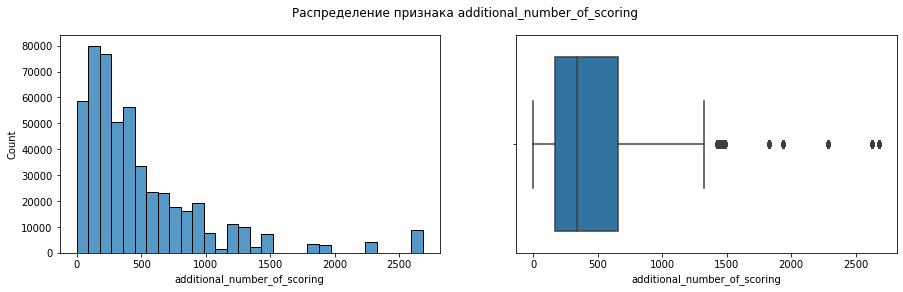

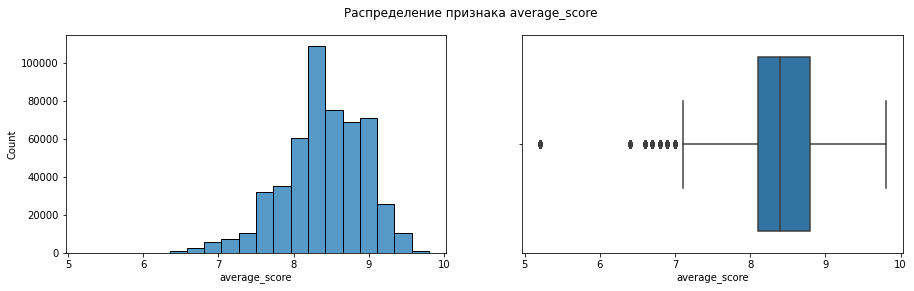

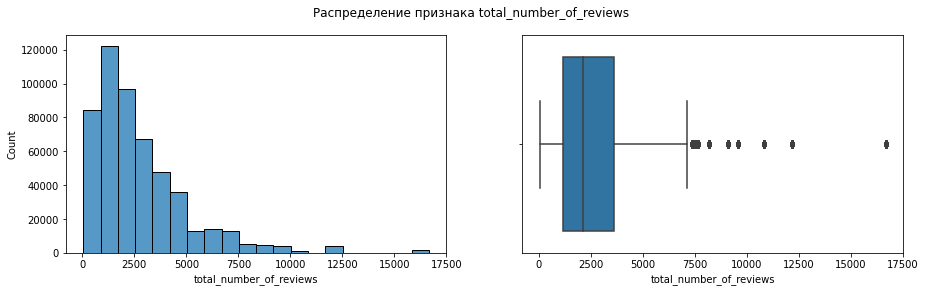

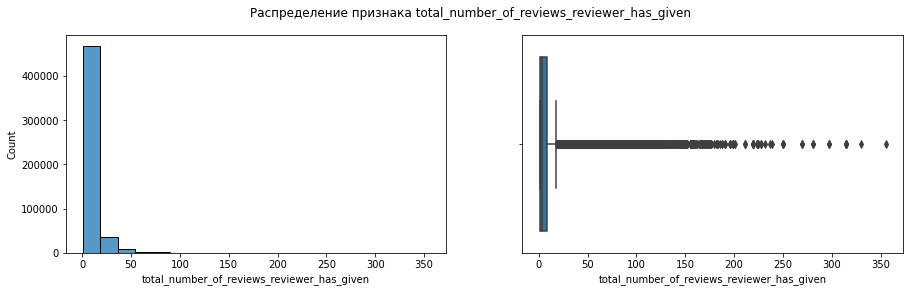

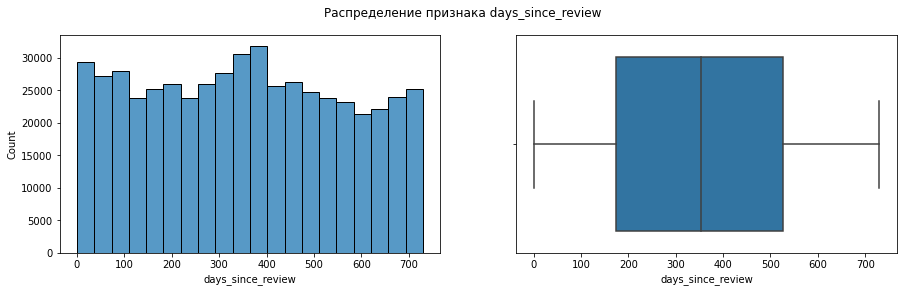

In [205]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
fig.suptitle('Распределение признака additional_number_of_scoring')
histplot = sns.histplot(x=hotel_df['additional_number_of_scoring'], bins=30, ax=axes[0])
boxplot = sns.boxplot(x=hotel_df['additional_number_of_scoring'], ax=axes[1])

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
fig.suptitle('Распределение признака average_score')
histplot = sns.histplot(x=hotel_df['average_score'], bins=20, ax=axes[0])
boxplot = sns.boxplot(x=hotel_df['average_score'], ax=axes[1])

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
fig.suptitle('Распределение признака total_number_of_reviews')
histplot = sns.histplot(x=hotel_df['total_number_of_reviews'], bins=20, ax=axes[0])
boxplot = sns.boxplot(x=hotel_df['total_number_of_reviews'], ax=axes[1])

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
fig.suptitle('Распределение признака total_number_of_reviews_reviewer_has_given')
histplot = sns.histplot(x=hotel_df['total_number_of_reviews_reviewer_has_given'], bins=20, ax=axes[0])
boxplot = sns.boxplot(x=hotel_df['total_number_of_reviews_reviewer_has_given'], ax=axes[1])

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
fig.suptitle('Распределение признака days_since_review ')
histplot = sns.histplot(x=hotel_df['days_since_review'], bins=20, ax=axes[0])
boxplot = sns.boxplot(x=hotel_df['days_since_review'], ax=axes[1])

[Вверх к содержанию](#Содержание)

# 5.FeatureEngineering

In [206]:
# кодируем столбец со странами
encoder = ce.OneHotEncoder(cols=['city_hotel']) # указываем столбец для кодирования
city_bin = encoder.fit_transform(hotel_df['city_hotel'])
hotel_df = pd.concat([hotel_df, city_bin], axis=1)

In [207]:
# кодируем столбец со странами
encoder = ce.OneHotEncoder(cols=['country_hotel']) # указываем столбец для кодирования
country_bin = encoder.fit_transform(hotel_df['country_hotel'])
hotel_df = pd.concat([hotel_df, country_bin], axis=1)

In [208]:
# Бинароное кодирование национальсти
bin_encoder = ce.BinaryEncoder(cols=['reviewer_nationality']) # указываем столбец для кодирования
reviewer_nationality_bin = bin_encoder.fit_transform(hotel_df['reviewer_nationality'])
hotel_df = pd.concat([hotel_df, reviewer_nationality_bin], axis=1)

hotel_df.head(3)

,Unnamed: 0,hotel_address,additional_number_of_scoring,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,...,country_hotel_5,country_hotel_6,reviewer_nationality_0,reviewer_nationality_1,reviewer_nationality_2,reviewer_nationality_3,reviewer_nationality_4,reviewer_nationality_5,reviewer_nationality_6,reviewer_nationality_7
0,0,Stratton Street Mayfair Westminster Borough Lo...,581,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,...,0,0,0,0,0,0,0,0,0,1
1,1,130 134 Southampton Row Camden London WC1B 5AF...,299,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,...,0,0,0,0,0,0,0,0,0,1
2,2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,...,0,0,0,0,0,0,0,0,1,0


In [78]:
%matplotlib inline

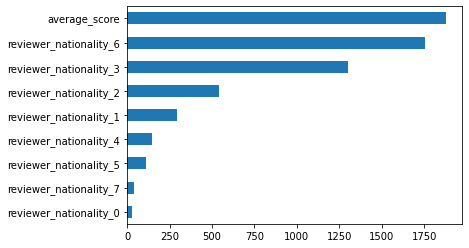

In [79]:
# категориальные признаки
cat_cols1 = ['average_score','reviewer_nationality_0', 'reviewer_nationality_1', 'reviewer_nationality_2', 
            'reviewer_nationality_3','reviewer_nationality_4', 'reviewer_nationality_5', 'reviewer_nationality_6', 
            'reviewer_nationality_7']

y=y.astype('int')

# влияние национальности на целевую переменную 
imp_cat = pd.Series(chi2(hotel_df[cat_cols1][:386803], y)[0], index=cat_cols1)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh');

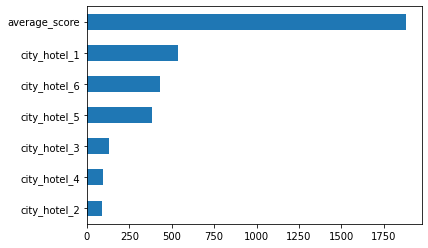

In [81]:
# категориальные признаки
cat_cols3 = ['average_score', 'city_hotel_1', 'city_hotel_2', 
            'city_hotel_3','city_hotel_4', 'city_hotel_5', 'city_hotel_6']

y=y.astype('int')

# влияние города отеля на целевую переменную 
imp_cat = pd.Series(chi2(hotel_df[cat_cols3][:386803], y)[0], index=cat_cols3)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh');

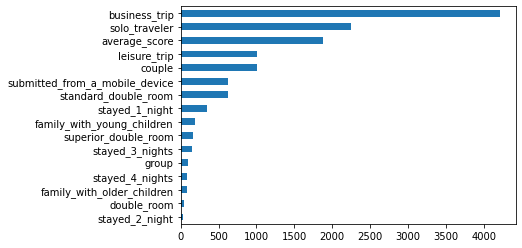

In [90]:
# категориальные признаки
cat_cols4 = ['average_score', 'leisure_trip', 'family_with_older_children', 'submitted_from_a_mobile_device', 
            'couple','stayed_1_night', 'stayed_2_night', 'solo_traveler', 'stayed_3_nights', 'business_trip',
             'group', 'family_with_young_children', 'stayed_4_nights', 'double_room', 'standard_double_room',
            'superior_double_room']

#y=y.astype('int')

# влияние самый часто используемых тэгов отеля на целевую переменную 
imp_cat = pd.Series(chi2(hotel_df[cat_cols4][:386803], y)[0], index=cat_cols4)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh');

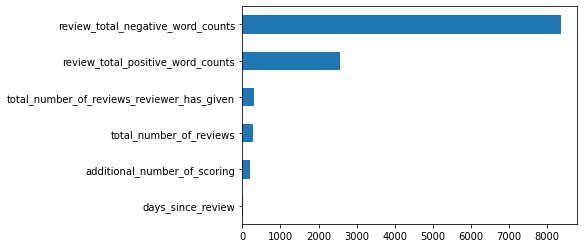

In [84]:
# непрерывные признаки
num_cols = ['total_number_of_reviews', 'additional_number_of_scoring', 'review_total_negative_word_counts',
            'review_total_positive_word_counts','days_since_review', 'total_number_of_reviews_reviewer_has_given']

# влияние всех непрерывных признаков на целевую переменную
imp_num = pd.Series(f_classif(hotel_df[num_cols][:386803], y)[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

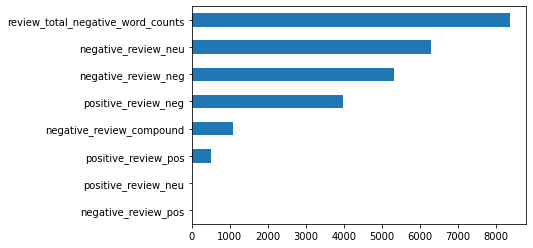

In [85]:
# непрерывные признаки
num_cols2 = ['review_total_negative_word_counts', 'positive_review_pos', 
            'positive_review_neu','positive_review_neg', 'negative_review_compound', 'negative_review_neg',
            'negative_review_neu', 'negative_review_pos']

# влияние всех непрерывных признаков на целевую переменную
imp_num = pd.Series(f_classif(hotel_df[num_cols2][:386803], y)[0], index = num_cols2)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

In [70]:
# загружаем спарсеные датафреймы отелей
hotel_paris = pd.read_csv('/content/drive/MyDrive/DataFrame/project_3_hotels/hotel_paris.csv')
hotel_paris = hotel_paris.drop('Unnamed: 0', axis=1)
hotel_paris.drop(index = [0], inplace = True)

hotel_barcelona = pd.read_csv('/content/drive/MyDrive/DataFrame/project_3_hotels/hotel_barcelona.csv')
hotel_barcelona = hotel_barcelona.drop('Unnamed: 0', axis=1)
hotel_barcelona.drop(index = [0], inplace = True)

hotel_amsterdam = pd.read_csv('/content/drive/MyDrive/DataFrame/project_3_hotels/hotel_amsterdam.csv')
hotel_amsterdam = hotel_amsterdam.drop('Unnamed: 0', axis=1)
hotel_amsterdam.drop(index = [0], inplace = True)

hotel_vienna = pd.read_csv('/content/drive/MyDrive/DataFrame/project_3_hotels/hotel_vienna.csv')
hotel_vienna = hotel_vienna.drop('Unnamed: 0', axis=1)
hotel_vienna.drop(index = [0], inplace = True)

hotel_london = pd.read_csv('/content/drive/MyDrive/DataFrame/project_3_hotels/hotel_london.csv')
hotel_london = hotel_london.drop('Unnamed: 0', axis=1)
hotel_london.drop(index = [0], inplace = True)

hotel_milan = pd.read_csv('/content/drive/MyDrive/DataFrame/project_3_hotels/hotel_milan.csv')
hotel_milan = hotel_milan.drop('Unnamed: 0', axis=1)
hotel_milan.drop(index = [0], inplace = True)

In [71]:
# объединяем их в один датафрейм
hotel_city_pars = hotel_paris.append(hotel_barcelona)
hotel_city_pars = hotel_city_pars.append(hotel_amsterdam)
hotel_city_pars = hotel_city_pars.append(hotel_vienna)
hotel_city_pars = hotel_city_pars.append(hotel_london)
hotel_city_pars = hotel_city_pars.append(hotel_milan)

hotel_city_pars = hotel_city_pars.drop_duplicates('hotel_address')
hotel_city_pars

,hotel_star,hotel_address,reviews_count,quality
1,4.0,11ruedutemple4tharr75004parisfrance,554 reviews,Very Good
2,4.0,19ruedubourgtibourg4tharr75004parisfrance,207 reviews,Excellent
3,4.0,ruesaintecroixdelabretonnerie4tharr75004parisf...,17 reviews,Very Good
4,4.0,58rueduroidesicile4tharr75004parisfrance,368 reviews,Excellent
5,4.0,19ruederivoli4tharr75004parisfrance,566 reviews,Wonderful
...,...,...,...,...
180,5.0,piazzadellarepubblica17,992 reviews,Wonderful
181,5.0,viaforcella6navigli,674 reviews,Wonderful
182,5.0,viaemiliocornalia7,692 reviews,Very Good
183,5.0,6viaaristotilefioravanti,"2,052 reviews",Excellent


In [211]:
# для корректного слияния нужно преобразовать адреса из Милана в вид, который мы получили в датафрейме
milan_hotel_list = hotel_df[hotel_df['city_hotel'] == 'Milan']['hotel_address'].to_list()
hotel_df['hotel_address'] = hotel_df['hotel_address'].apply(
    lambda x: re.sub("[^0-9a-zA-Z]"," ",x).split(' ')[:4] if x in milan_hotel_list else x)

# переводим обратно в строку и избавляемся от пробелов + приводим все к нижнему регистру
hotel_df['hotel_address'] = hotel_df['hotel_address'].apply(lambda x: ' '.join(x))
hotel_df['hotel_address'] = hotel_df['hotel_address'].apply(lambda x: x.lower().replace(' ', ''))

hotel_df = hotel_df.merge(hotel_city_pars,
                on = 'hotel_address',
                how = 'left')

# смотри на итоговое количество пропусков
null = hotel_df.isnull().mean() * 100
null_perc = null[null > 0]
null_perc

hotel_star       17.796439
reviews_count    17.937015
quality          17.937015
dtype: float64

In [238]:
# функция для выделения количества отзывов отелей в значениях
def get_reviews_count(reviews_count):
    if type(reviews_count) == str:
        return reviews_count.split(' ')[0].replace(',', '')
    else:
        return np.nan

hotel_df['reviews_count'] = hotel_df['reviews_count'].apply(get_reviews_count)

In [246]:
# функция для удаления лишних пробелом в конце значения
def quality(q):
    if type(q) == str:
        return q.strip()
    else:
        return np.nan
  
hotel_df['quality'] = hotel_df['quality'].apply(quality)

In [255]:
print(hotel_df['hotel_star'].mode())
print(hotel_df['quality'].mode())

0    4.0
dtype: float64
0    Very Good
dtype: object


In [ ]:
# заполним пропуски модальным значением и медианой
value_pars = ({
    'hotel_star' : 4.0,
    'reviews_count' : hotel_df['reviews_count'].median(),
    'quality' : 'Very Good'
})

hotel_df = hotel_df.fillna(value_pars)

In [256]:
# напишем функцию для преобразования в числовой признак, 1 - самый лучший, 8 - худший 
def get_quality(quality):
    if quality == 'Disappointing':
        return 1
    elif quality == 'Exceptional':
        return 8
    elif quality == 'Fair':
        return 2
    elif quality == 'Pleasant':
        return 3
    elif quality == 'Wonderful':
        return 7
    elif quality == 'Excellent':
        return 6
    elif quality == 'Good':
        return 4
    elif quality == 'Very Good':
        return 5


# избавляемся от лишних пробелом и применяем функцию
hotel_df['quality'] = hotel_df['quality'].apply(get_quality)

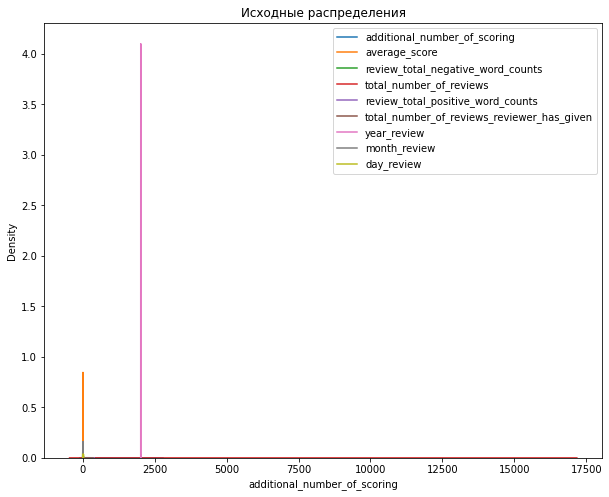

In [260]:
# зададим параметры холста, название и визуализируем кривые распределения:
fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 8))
ax1.set_title('Исходные распределения')

# kdeplot() (KDE – оценка плотности ядра) – специальный метод для графиков распределений
sns.kdeplot(hotel_df['additional_number_of_scoring'], ax=ax1, label ='additional_number_of_scoring')
sns.kdeplot(hotel_df['average_score'], ax=ax1, label ='average_score')
sns.kdeplot(hotel_df['review_total_negative_word_counts'], ax=ax1, label ='review_total_negative_word_counts')
sns.kdeplot(hotel_df['total_number_of_reviews'], ax=ax1, label ='total_number_of_reviews')
sns.kdeplot(hotel_df['review_total_positive_word_counts'], ax=ax1, label ='review_total_positive_word_counts')
sns.kdeplot(hotel_df['total_number_of_reviews_reviewer_has_given'], ax=ax1, label ='total_number_of_reviews_reviewer_has_given')
sns.kdeplot(hotel_df['year_review'], ax=ax1, label ='year_review')
sns.kdeplot(hotel_df['month_review'], ax=ax1, label ='month_review')
sns.kdeplot(hotel_df['day_review'], ax=ax1, label ='day_review')

plt.legend();

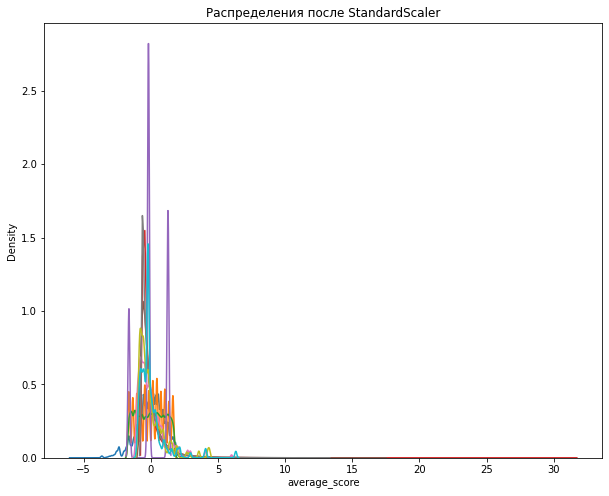

In [261]:
col_names = ['day_review', 'total_number_of_reviews_reviewer_has_given', 'year_review',
                'review_total_positive_word_counts', 'total_number_of_reviews',
                'review_total_negative_word_counts', 'additional_number_of_scoring', 'month_review', 'average_score',
                'reviews_count']

# инициализируем стандартизатор StandardScaler
s_scaler = preprocessing.StandardScaler()

# копируем исходный датасет
df_s = s_scaler.fit_transform(hotel_df[['day_review', 'total_number_of_reviews_reviewer_has_given', 'year_review',
                                            'review_total_positive_word_counts', 'total_number_of_reviews',
                                            'review_total_negative_word_counts', 'additional_number_of_scoring',
                                            'month_review', 'average_score', 'reviews_count']])

# Преобразуем промежуточный датасет в полноценный датафрейм для визуализации
df_s = pd.DataFrame(df_s, columns=col_names)

fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 8))
ax1.set_title('Распределения после StandardScaler')

sns.kdeplot(df_s['average_score'], ax=ax1)
sns.kdeplot(df_s['month_review'], ax=ax1)
sns.kdeplot(df_s['day_review'], ax=ax1)
sns.kdeplot(df_s['total_number_of_reviews_reviewer_has_given'], ax=ax1)
sns.kdeplot(df_s['year_review'], ax=ax1)
sns.kdeplot(df_s['review_total_positive_word_counts'], ax=ax1)
sns.kdeplot(df_s['total_number_of_reviews'], ax=ax1)
sns.kdeplot(df_s['review_total_negative_word_counts'], ax=ax1)
sns.kdeplot(df_s['additional_number_of_scoring'], ax=ax1)
sns.kdeplot(df_s['reviews_count'], ax=ax1);

In [262]:
# присваиваем стандартизированные значения
hotel_df[col_names] = df_s

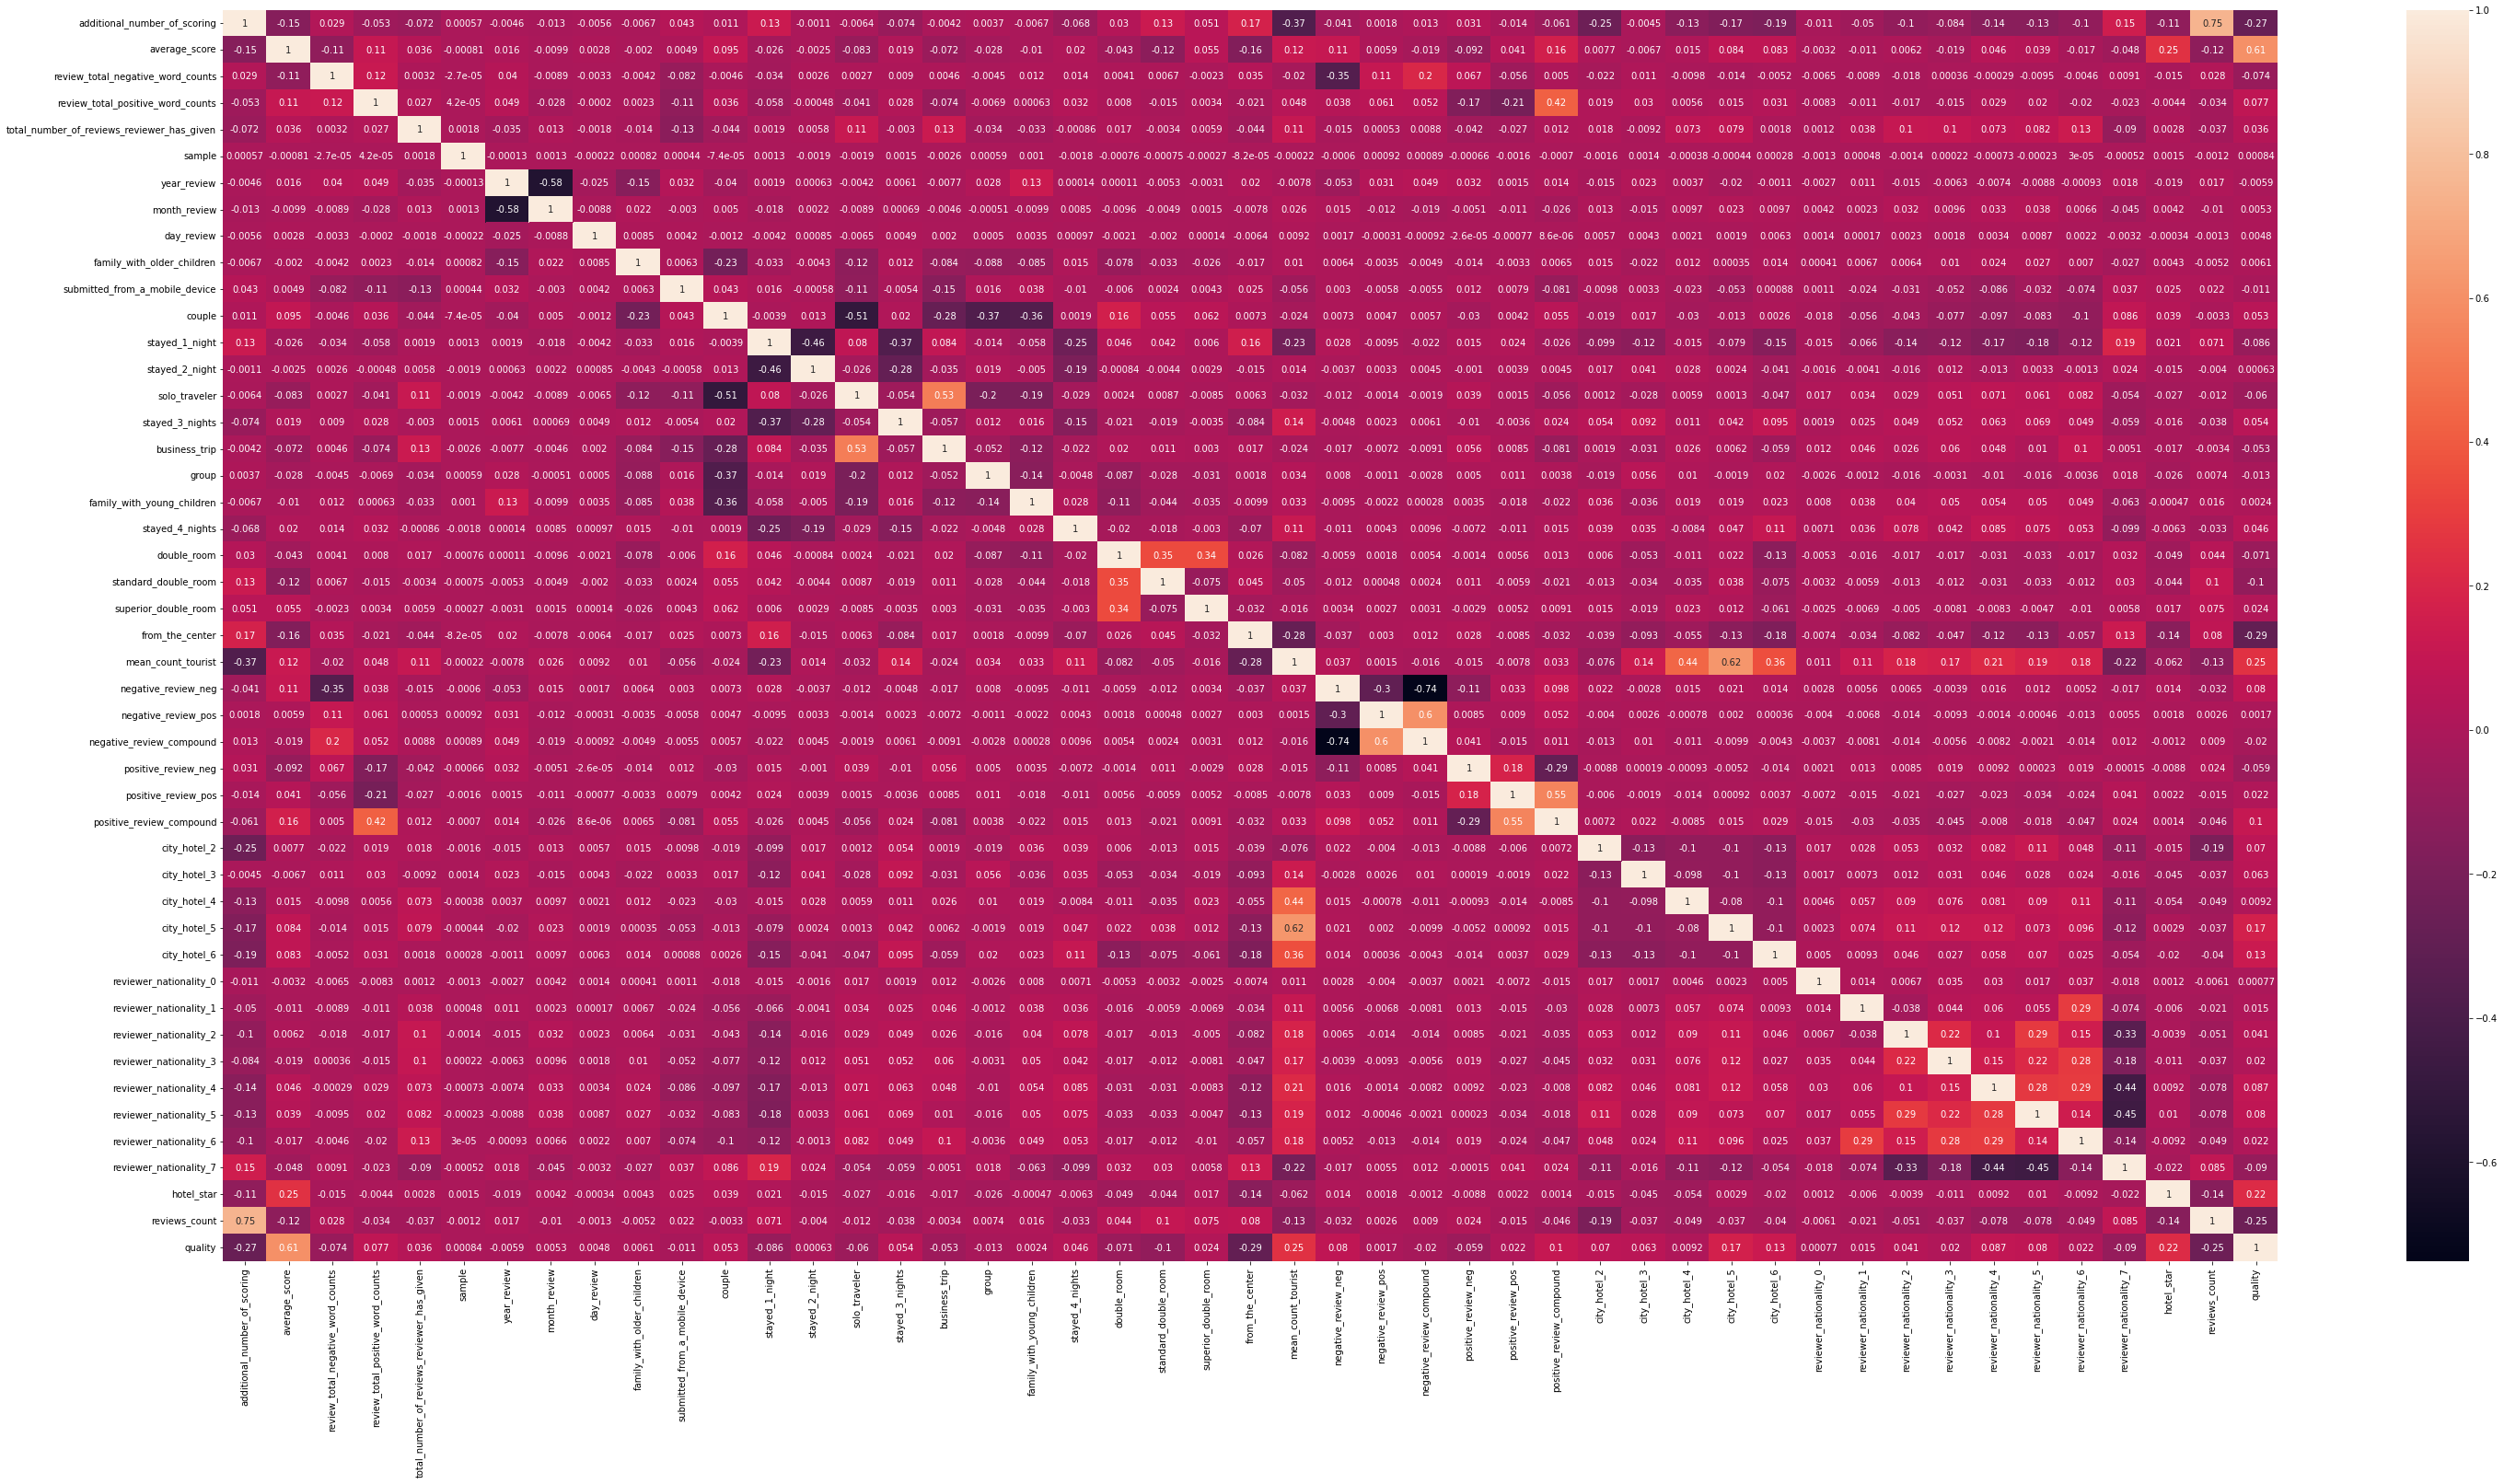

In [300]:
fig = plt.figure(figsize=(50,25))
sns.heatmap(hotel_df.corr(), annot=True);

In [264]:
#удаляем страны, так как они просто дублируют с городами
hotel_df = hotel_df.drop(['country_hotel', 'country_hotel_1', 'country_hotel_2', 'country_hotel_3',
                          'country_hotel_4', 'country_hotel_5', 'country_hotel_6'], axis=1)

In [265]:
#удалим сильно коррелирующие признаки
hotel_df = hotel_df.drop(['lat', 'lng', 'days_since_review', 'leisure_trip', 'negative_review_neu',
                          'positive_review_neu', 'total_number_of_reviews', 'city_hotel_1'], axis=1)

In [267]:
# удалим все признаки с типом object
object_columns = [s for s in hotel_df.columns if hotel_df[s].dtypes == 'object']
hotel_df.drop(object_columns, axis = 1, inplace=True)

In [269]:
hotel_df = hotel_df.drop('Unnamed: 0', axis=1)

In [270]:
hotel_df.to_csv('/content/drive/MyDrive/DataFrame/project_3_hotels/hotels')

[Вверх к содержанию](#Содержание)

# 6.Моделирование

In [7]:
X = hotel_df.query('sample == 1').drop('sample', axis=1) # отделяем тренинговый сет

In [8]:
hotel_df_train = pd.read_csv('/content/drive/MyDrive/DataFrame/project_3_hotels/hotels_train.csv', sep=',')
y = hotel_df_train['reviewer_score'] # выделяем таргет

In [9]:
# Загружаем специальный инструмент для разбивки:  
from sklearn.model_selection import train_test_split  

In [10]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.  
# Для тестирования мы будем использовать 25% от исходного датасета.  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [11]:
# Импортируем необходимые библиотеки:  
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели  
from sklearn import metrics # инструменты для оценки точности модели  
  
# Создаём модель  
regr = RandomForestRegressor(n_estimators=100)  
      
# Обучаем модель на тестовом наборе данных  
regr.fit(X_train, y_train)  
      
# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X_test)  


In [12]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических.  
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAPE: 0.12537990503168472


### 6.1 Формирование файла Submission

In [13]:
X_sub = hotel_df.query('sample == 0').drop('sample', axis=1)

In [18]:
DIR = '/content/drive/MyDrive/DataFrame/project_3_hotels/'

sample_submission = pd.read_csv(DIR + 'sample_submission.csv', sep=',')

In [21]:
predict_submission = np.round(regr.predict(X_sub), 1)
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv(DIR + 'submission.csv', index=False)

submission = pd.read_csv(DIR + 'submission.csv')
submission.head(10)

,reviewer_score,id
0,8.4,488440
1,7.2,274649
2,8.6,374688
3,9.5,404352
4,9.4,451596
5,8.9,302161
6,7.8,317079
7,7.9,13963
8,8.2,159785
9,7.3,195089


[Вверх к содержанию](#Содержание)